In [76]:
import numpy as np
import matplotlib.pyplot as plt

import utils.preprocessing_utils as preproc
from utils.data_utils import IDMT

In [43]:
def fourier_decomposition(vector,floor_threshold=.01):
    # Compute the FFT of the input array
    fourier = np.fft.fft(vector)
    
    power_spectrum = np.abs(fourier)

    # filter out exceptionally small frequencies
    power_spectrum = power_spectrum[power_spectrum >= floor_threshold]

    # Compute the frequencies corresponding to the FFT result
    frequency_coefficients = np.fft.fftfreq(len(power_spectrum))
    return power_spectrum, frequency_coefficients

def plot_spectrum(power_spectrum, frequency_coefficients):
    plt.plot(frequency_coefficients,power_spectrum,linewidth=.5)

    plt.xlim(0,max(frequency_coefficients))
    plt.title("Power Spectral Density of the Sunspot Number Time Series")
    plt.grid(True)

def engineer_features(power_spectrum, frequency_coefficients):

    max_index = np.argmax(power_spectrum)

    dominant_frequency = power_spectrum[max_index]
    power = frequency_coefficients[max_index]

    return dominant_frequency,power

power_spectrum, frequency_coefficients = fourier_decomposition(audio)

# plot_spectrum(power_spectrum, frequency_coefficients)


dominant_frequency,power = engineer_features(power_spectrum, frequency_coefficients)
dominant_frequency,power

# plt.text(frequency_coefficients[max_index], power_spectrum[max_index], f'X')


(154.81262600926462, 0.0006145897353097428)

In [77]:
length = 100
freq = 1
x = np.arange(0,length)

signal = np.sin(freq*x) + np.sin(freq*2*x)

In [100]:
def process(audio):

    # https://www.youtube.com/watch?v=aQKX3mrDFoY

    fft = np.fft.fft(audio)
    fft = np.abs(fft)[0:int(len(audio)/2)]
    compressed_fft = preproc.compressVector(fft,compression_factor=100)
    return fft,compressed_fft

def plot(audio,fft,compressed_fft):

    fig, axes = plt.subplots(4,figsize=(15,8))

    axes[0].plot(audio,linewidth=.5)

    # plt.semilogx(fft,linewidth=.5)
    axes[1].plot(fft,linewidth=.5)

    axes[2].plot(compressed_fft,linewidth=.5)

    axes[3].semilogx(compressed_fft,linewidth=.5)

In [84]:
idmt = IDMT(log=False,compression_factor=None)
paths = idmt.getFilePaths()

In [112]:
df = idmt.getFeatureDF(paths)
classes = np.unique(df['class'].values)

In [113]:
def label_embedding(label):
    embedding = [1 if class_ == label else 0 for class_ in classes]
    return embedding

label_embedding('C')

[0, 1, 0, 0]

In [114]:
index = 2
path = paths[index]
audio = idmt.extractAudio(path)
features = idmt.extractFeatures(path)
label = features[idmt.columns.index('class')]
labels = label_embedding(label)

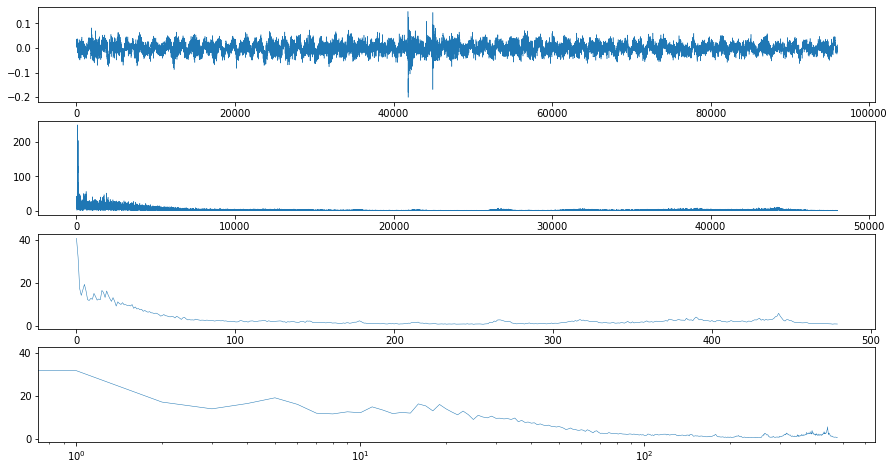

In [101]:
fft,compressed_fft = process(audio)

plot(audio,fft,compressed_fft)

In [102]:
compressed_fft.shape

(480,)

In [118]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    """ResNet model

    outputs 4 numbers, corresponding to a vector of probabilities for each possible class (car, truck, etc)
    """

    def __init__(self):
        super(Net, self).__init__()
        self.fc = nn.Linear(480, 4)

    def forward(self, x):
        x = self.fc(x)
        return x

In [92]:
import torch.optim as optim
# import torch.nn as nn

# baseline loss function
criterion = nn.CrossEntropyLoss()

def training_loop(model,inputs,labels) -> "loss":

    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward pass
    outputs = model(inputs)

    # calculate baseline loss + modulated regularization value
    loss = criterion(outputs, labels)

    # calculate gradients with respect to loss
    loss.backward()

    # apply gradients to parameters
    optimizer.step()

    # return loss value for analysis
    return loss.item()

In [119]:
model = Net()

inputs = torch.Tensor(compressed_fft)
labels = torch.Tensor(labels)

training_loop(model,inputs,labels)

1.8520936965942383